<a href="https://colab.research.google.com/github/EmilStalvinge/statML/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from sklearn import tree
from sklearn import ensemble
from sklearn import model_selection

import graphviz
from graphviz import Graph

sns.set_theme()

# Prepare the data 

In [ ]:
# Import the data
training_data = pd.read_csv("training_data.csv")          # training data 750 labeled songs
songs_to_classify = pd.read_csv("songs_to_classify.csv")  # make predictions for the submission (unlabeled data)

## Briefly inspect the data

In [ ]:
training_data.head()

In [ ]:
songs_to_classify.head() # Note that the label column is missing

In [ ]:
training_data.describe() # Note the very different mean and std, this data needs to be normalized

## Split the data for training and testing

In [ ]:
# Drop the columns that were considered to be unimportant
train_data = training_data.drop(columns=["mode", "key"])

In [ ]:
# Split data into train and test datasets
np.random.seed(1)

"""
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    train_data.drop(columns="label"), train_data["label"], test_size=0.2)
"""

trainI = np.random.choice(train_data.shape[0], size = 600, replace = False)
trainIndex = train_data.index.isin(trainI)
train = train_data.iloc[trainIndex]
test = train_data.iloc[~trainIndex]

X_train = train.drop(columns="label")
Y_train = train["label"]
X_test = test.drop(columns="label")
Y_test = test["label"]

In [ ]:
# Normalize the data
scaler = skl_pre.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Try different Classifiers

## Choose model

In [ ]:
model_logreg = skl_lm.LogisticRegression()
model_lda = skl_da.LinearDiscriminantAnalysis()
model_tree = tree.DecisionTreeClassifier(max_depth=3)
model_bagging= ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=3),n_estimators = 100)
model_r_forest = ensemble.RandomForestClassifier(max_depth=3, n_estimators=100)
model_boosting = ensemble.AdaBoostClassifier(base_estimator=ensemble.RandomForestClassifier(max_depth=3), n_estimators=100)

models = [model_logreg,model_lda, model_tree, model_bagging, model_r_forest, model_boosting] # for ROC graph

In [ ]:
# Choose model
model = model_r_forest

## Train model

In [ ]:
model.fit(X_train, Y_train)
print(model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


## Test model

In [ ]:
predictions = model.predict(X_test)
print("accuracy:")
print(round(np.mean(predictions == Y_test),3))
print("\nconfusion matrix:")
pd.crosstab(predictions, Y_test)

accuracy:
0.773

confusion matrix:


label,0,1
row_0,,
0,43,15
1,19,73


## Compare models

### ROC Graph

In [ ]:
positive_class = 1
negative_class = 0
P = np.sum(Y_test == positive_class) # number of positive examples in test data
N = np.sum(Y_test == negative_class) # number of negative examples in test data

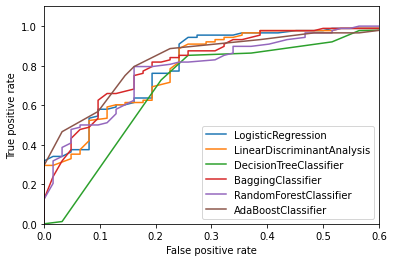

In [ ]:
for model in models:
    model.fit(X_train, Y_train)
    predict_proba = model.predict_proba(X_test)
    positive_class_index = np.argwhere(model.classes_ == positive_class).squeeze() # 1
    true_positive_rate = []
    false_positive_rate = []

    threshold = np.linspace(0.00,1,101)
    for r in threshold:
        prediction = np.where(predict_proba[:, positive_class_index] > r,
                              positive_class, negative_class)
        FP = np.sum((prediction == positive_class)&(Y_test == negative_class)) # False Positive
        TP = np.sum((prediction == positive_class)&(Y_test == positive_class)) # True Positive
        false_positive_rate.append(FP/N)
        true_positive_rate.append(TP/P)
        
    plt.plot(false_positive_rate, true_positive_rate, label= type(model).__name__)   
    
plt.xlim([0,0.6])
plt.ylim([0,1.1]);
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.savefig('roc.png', dpi=300)
plt.show()

## T- coefficients (only for models Logistic regression and LDA)

In [ ]:
# The resulting transformation coefficients
# Creates and displays a table with the corresponding coefficient of each song feature.

assert type(model) in [skl_lm.LogisticRegression, skl_da.LinearDiscriminantAnalysis], "This cell is meant to be run using either a Logistic regression model or an LDA model"

coefs = pd.DataFrame(model.coef_.T, columns=["coefficient"])
coefs["feature"] = ['acousticness', 'danceability','duration', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence']

coefs[["feature", "coefficient"]]

,feature,coefficient
0,acousticness,0.676100
1,danceability,-0.413888
2,duration,0.169963
3,energy,-0.484885
4,instrumentalness,-0.319150
5,liveness,-0.169343
6,loudness,-0.255365
7,speechiness,-1.265728
8,tempo,0.115001
9,time_signature,-0.051901


## LDA projection of the data

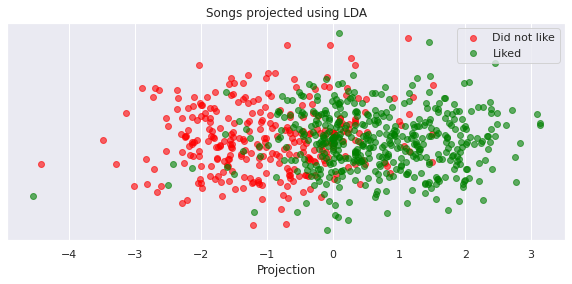

In [ ]:
# Visualize the LDA projection
# Plotted with additional vertical scattering in order to better visualize the class densities

X = training_data.drop(columns=["label", "mode", "key"])        # Remove specified columns
X = skl_pre.StandardScaler().fit_transform(X)                   # Data normalization
y = training_data["label"]
model_lda = skl_da.LinearDiscriminantAnalysis()
projected_data = model.fit_transform(X, y).flatten()            # Project the data onto the linear space that provides
                                                                # the maximal seperation of classes

colors = ["red", "green"]
target_names = ["Did not like", "Liked"]

fig = plt.figure(figsize=(10, 4))
for color, i, target_name in zip(colors, [0, 1], target_names): # Pairs each class with a color and a target name
    class_data = projected_data[y == i]
    plt.scatter(class_data, np.random.randn(class_data.shape[0]), alpha=.6, color=color, label=target_name)

fig.axes[0].get_yaxis().set_ticks([])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("Songs projected using LDA")
plt.xlabel("Projection")

plt.show()

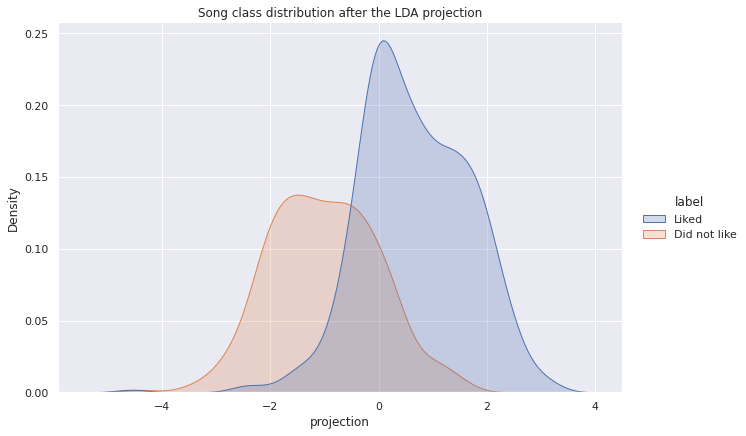

In [ ]:
projected_data_viz = pd.DataFrame(data=projected_data, columns=["projection"])
projected_data_viz.loc[:, "label"] = np.where(y, "Liked", "Did not like")

sns.displot(data=projected_data_viz, x="projection", hue="label", height=6, aspect=1.5, kind="kde", fill=True).set(title="Song class distribution after the LDA projection")

## Tree features importance

In [ ]:
# Shows how important each of the song features were for constructing the decision model

assert type(model) in [tree.DecisionTreeClassifier, ensemble.RandomForestClassifier], "This cell is meant to be run using a tree based model"

features = ['acousticness', 'danceability','duration', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature','valence']

tree_feature_importance = pd.DataFrame(model.feature_importances_.T, columns=["importance"])
tree_feature_importance["feature"] = features

tree_feature_importance.sort_values(by="importance", ascending=False).reset_index()[["feature", "importance"]]

AssertionError: ignored

## Plot the tree (only for model tree)

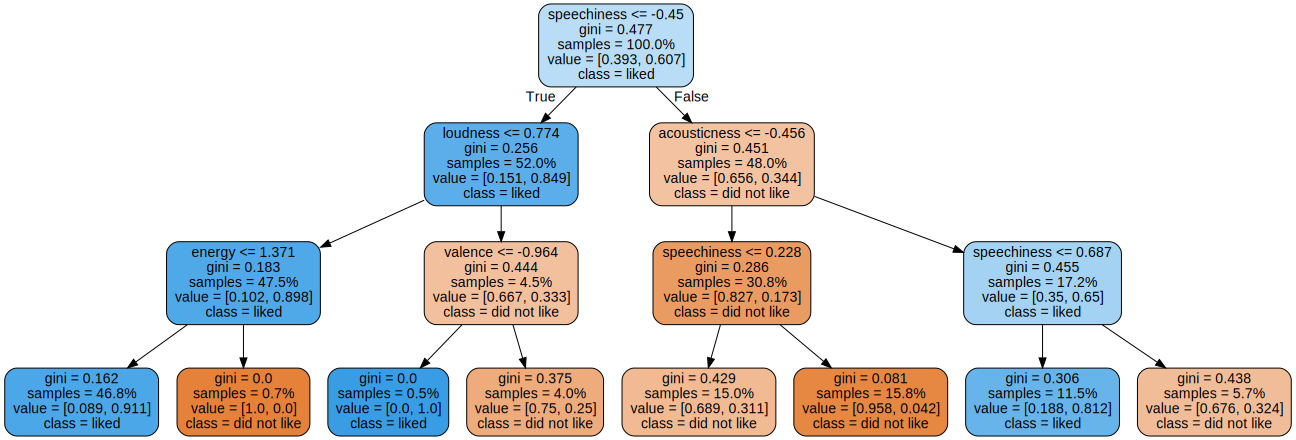

In [ ]:

assert type(model) is tree.DecisionTreeClassifier, "This cell is meant to be run using the Decision Tree model"

dot_data = tree.export_graphviz(model, out_file = None, feature_names = features,
                                class_names = ["did not like", "liked"], filled = True, rounded = True,
                                leaves_parallel=True, proportion=True)
graph = graphviz.Source(dot_data)
graph
# graph.render('tree', view=True)

## Make submission

In [ ]:
# Get the full unsplitted train dataset
train_data = training_data.drop(columns=["mode", "key"])
test_data= songs_to_classify.drop(columns=["mode", "key"])
X_train = train_data.drop(columns="label")
Y_train = train_data["label"]

# Normalize the data
scaler = skl_pre.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(test_data)

# Fit model
model.fit(X_train, Y_train)

# Make predictions
predictions = model.predict(X_test)

# Print out the leaderboard submission string
"".join(np.array2string(predictions).split())[1:-1]

'11100101011111011000101111111001110111110100110100000110110011000100110011010000101111110011100011111010011010111011111111110001011011111101111110101011101101111010010101111010101110101010101111111000'